## 準備

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
from pathlib import Path

root = '/content/drive/MyDrive/Qiita/LayerSpeedAndParam/'

In [14]:
# 環境ファイル出力
!cat /etc/os-release > {root}os.txt
!cat /proc/cpuinfo > {root}cpu.txt
!nvidia-smi > {root}gpu.txt
!python -V > {root}python.txt
!pip show torch > {root}torch.txt

In [15]:
root = Path(root)

In [6]:
%%capture
!pip install torchinfo

In [22]:
from time import time
from itertools import product

import torch
from torch import nn
from torchinfo import summary
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import display

In [8]:
n_iter = 100

batches = [1]
features = [16, 64, 256, 1024, 2048]
lengths = [16, 64, 256, 1024, 2048]

devices = ['cuda']

## 全結合層

In [17]:
dir_ = root / 'Linear'
dir_.mkdir(parents=True, exist_ok=True)
csv_path = dir_ / 'result.csv'

In [18]:
out_features = [16, 64, 256, 1024, 2048]

looper = product(batches, features, lengths, out_features, devices)

column = ['Batch', 'Input_Feature', 'Length', 'Output_Feature', 'Device', 'Time', 'Mult-Adds', 'Params']

In [20]:
if csv_path.exists():
  df = pd.read_csv(csv_path)
else:
  data = []
  looper = tqdm(list(looper), leave=True)

  for B, Fin, L, Fout, D in looper:
    x = torch.rand(B, L, Fin, device=D)
    layer = nn.Linear(Fin, Fout, device=D)
    stats = summary(layer, input_data=x, verbose=0, device=D)
    with torch.no_grad():
      _ = layer(x)

    t = 0
    for _ in range(n_iter):
      torch.cuda.synchronize()
      start = time()

      with torch.no_grad():
        _ = layer(x)

      torch.cuda.synchronize()
      elapsed = time() - start
      t += elapsed

    avg = t / n_iter
    mads = stats.total_mult_adds
    params = stats.total_params
    col = [B, Fin, L, Fout, D, avg, mads, params]
    data.append(col)


  df = pd.DataFrame(data, columns=column)
  df.to_csv(csv_path)

,Unnamed: 0,Batch,Input_Feature,Length,Output_Feature,Device,Time,Mult-Adds,Params
104,104,1,2048,16,2048,cuda,0.000141,4196352,4196352
109,109,1,2048,64,2048,cuda,0.000173,4196352,4196352
114,114,1,2048,256,2048,cuda,0.000740,4196352,4196352
119,119,1,2048,1024,2048,cuda,0.002289,4196352,4196352
124,124,1,2048,2048,2048,cuda,0.004879,4196352,4196352


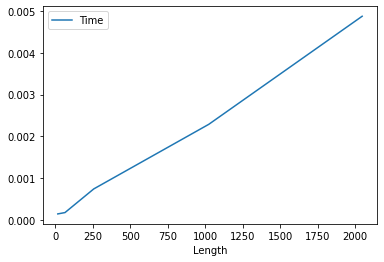

In [24]:
plt.close('all')
q = 'Device == "cuda" and Input_Feature == 2048 and Output_Feature == 2048'
df_ = df.query(q)
display(df_)
df_.plot(x='Length',y='Time')
path = dir_ / 'Length.png'
plt.savefig(path)

,Unnamed: 0,Batch,Input_Feature,Length,Output_Feature,Device,Time,Mult-Adds,Params
24,24,1,16,2048,2048,cuda,0.000178,34816,34816
49,49,1,64,2048,2048,cuda,0.000318,133120,133120
74,74,1,256,2048,2048,cuda,0.000608,526336,526336
99,99,1,1024,2048,2048,cuda,0.002256,2099200,2099200
124,124,1,2048,2048,2048,cuda,0.004879,4196352,4196352


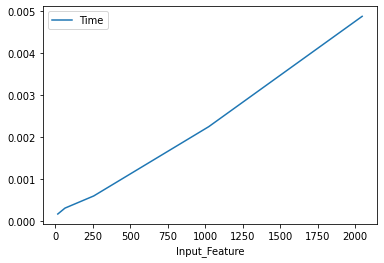

In [25]:
plt.close('all')
q = 'Device == "cuda" and Length == 2048 and Output_Feature == 2048'
df_ = df.query(q)
display(df_)
df_.plot(x='Input_Feature',y='Time')
path = dir_ / 'Input_Feature.png'
plt.savefig(path)

,Unnamed: 0,Batch,Input_Feature,Length,Output_Feature,Device,Time,Mult-Adds,Params
120,120,1,2048,2048,16,cuda,0.000182,32784,32784
121,121,1,2048,2048,64,cuda,0.000223,131136,131136
122,122,1,2048,2048,256,cuda,0.000621,524544,524544
123,123,1,2048,2048,1024,cuda,0.002250,2098176,2098176
124,124,1,2048,2048,2048,cuda,0.004879,4196352,4196352


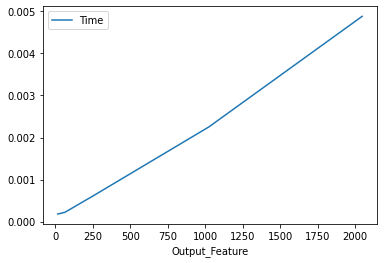

In [27]:
plt.close('all')
q = 'Device == "cuda" and Length == 2048 and Input_Feature == 2048'
df_ = df.query(q)
display(df_)
df_.plot(x='Output_Feature',y='Time')
path = dir_ / 'Output_Feature.png'
plt.savefig(path)

## 畳み込み層

In [30]:
dir_ = root / 'Conv'
dir_.mkdir(parents=True, exist_ok=True)
csv_path = dir_ / 'result.csv'

In [31]:
filters = [16, 64, 256, 1024, 2048]
kernels = [1, 4, 8, 16, 64]
strides = [1, 4, 8, 16, 64]

looper = product(batches, features, lengths, filters, kernels, strides, devices)

column = ['Batch', 'Input_Feature', 'Length', 'Output_Feature', 'Kernel', 'Stride', 'Device', 'Time', 'Mult-Adds', 'Params']

In [33]:
if csv_path.exists():
  df = pd.read_csv(csv_path)
else:
  data = []
  looper = tqdm(list(looper), leave=True)

  for B, Fin, L, Fout, K, S, D in looper:
    if L < K:
      continue
    x = torch.rand(B, Fin, L, device=D)
    layer = nn.Conv1d(Fin, Fout, K, S, device=D)
    stats = summary(layer, input_data=x, verbose=0, device=D)
    with torch.no_grad():
      _ = layer(x)

    t = 0
    for _ in range(n_iter):
      torch.cuda.synchronize()
      start = time()

      with torch.no_grad():
        _ = layer(x)

      torch.cuda.synchronize()
      elapsed = time() - start
      t += elapsed

    avg = t / n_iter
    mads = stats.total_mult_adds
    params = stats.total_params
    col = [B, Fin, L, Fout, K, S, D, avg, mads, params]
    data.append(col)


  df = pd.DataFrame(data, columns=column)
  df.to_csv(csv_path)

  0%|          | 0/3125 [00:00<?, ?it/s]

,Batch,Input_Feature,Length,Output_Feature,Kernel,Stride,Device,Time,Mult-Adds,Params
2620,1,2048,64,2048,64,1,cuda,0.026818,268437504,268437504
2745,1,2048,256,2048,64,1,cuda,0.038854,51808438272,268437504
2870,1,2048,1024,2048,64,1,cuda,0.153202,257968441344,268437504
2995,1,2048,2048,2048,64,1,cuda,0.255082,532848445440,268437504


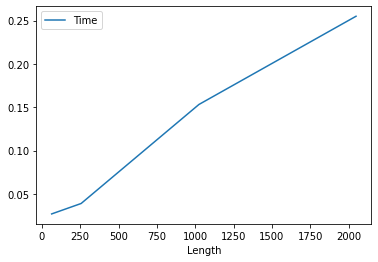

In [34]:
plt.close('all')
q = 'Device == "cuda" and Input_Feature == 2048 and Output_Feature == 2048 and Kernel == 64 and Stride == 1'
df_ = df.query(q)
display(df_)
df_.plot(x='Length',y='Time')
path = dir_ / 'Length.png'
plt.savefig(path)

,Batch,Input_Feature,Length,Output_Feature,Kernel,Stride,Device,Time,Mult-Adds,Params
2895,1,2048,2048,16,64,1,cuda,0.023063,4162878480,2097168
2920,1,2048,2048,64,64,1,cuda,0.034157,16651513920,8388672
2945,1,2048,2048,256,64,1,cuda,0.031040,66606055680,33554688
2970,1,2048,2048,1024,64,1,cuda,0.141763,266424222720,134218752
2995,1,2048,2048,2048,64,1,cuda,0.255082,532848445440,268437504


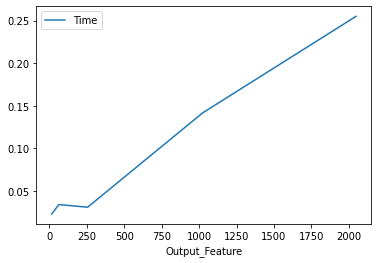

In [35]:
plt.close('all')
q = 'Device == "cuda" and Input_Feature == 2048 and Length == 2048 and Kernel == 64 and Stride == 1'
df_ = df.query(q)
display(df_)
df_.plot(x='Output_Feature',y='Time')
path = dir_ / 'Output_Feature.png'
plt.savefig(path)

,Batch,Input_Feature,Length,Output_Feature,Kernel,Stride,Device,Time,Mult-Adds,Params
595,1,16,2048,2048,64,1,cuda,0.002030,4166912000,2099200
1195,1,64,2048,2048,64,1,cuda,0.007836,16655452160,8390656
1795,1,256,2048,2048,64,1,cuda,0.029827,66609612800,33556480
2395,1,1024,2048,2048,64,1,cuda,0.123781,266426255360,134219776
2995,1,2048,2048,2048,64,1,cuda,0.255082,532848445440,268437504


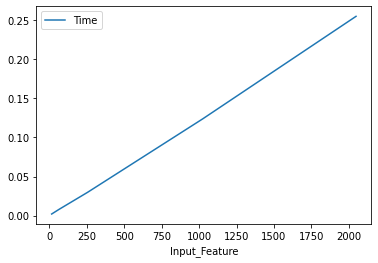

In [36]:
plt.close('all')
q = 'Device == "cuda" and Output_Feature == 2048 and Length == 2048 and Kernel == 64 and Stride == 1'
df_ = df.query(q)
display(df_)
df_.plot(x='Input_Feature',y='Time')
path = dir_ / 'Input_Feature.png'
plt.savefig(path)

,Batch,Input_Feature,Length,Output_Feature,Kernel,Stride,Device,Time,Mult-Adds,Params
2975,1,2048,2048,2048,1,1,cuda,0.004877,8594128896,4196352
2980,1,2048,2048,2048,4,1,cuda,0.016554,34313594880,16779264
2985,1,2048,2048,2048,8,1,cuda,0.032099,68488775680,33556480
2990,1,2048,2048,2048,16,1,cuda,0.063535,136436484096,67110912
2995,1,2048,2048,2048,64,1,cuda,0.255082,532848445440,268437504


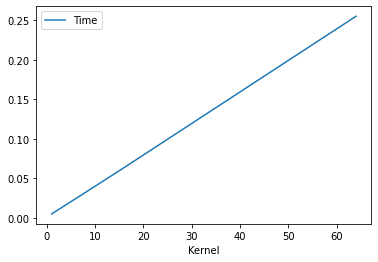

In [37]:
plt.close('all')
q = 'Device == "cuda" and Input_Feature == 2048 and Output_Feature == 2048 and Length == 2048 and Stride == 1'
df_ = df.query(q)
display(df_)
df_.plot(x='Kernel',y='Time')
path = dir_ / 'Kernel.png'
plt.savefig(path)

,Batch,Input_Feature,Length,Output_Feature,Kernel,Stride,Device,Time,Mult-Adds,Params
2975,1,2048,2048,2048,1,1,cuda,0.004877,8594128896,4196352
2976,1,2048,2048,2048,1,4,cuda,0.001318,2148532224,4196352
2977,1,2048,2048,2048,1,8,cuda,0.000874,1074266112,4196352
2978,1,2048,2048,2048,1,16,cuda,0.000764,537133056,4196352
2979,1,2048,2048,2048,1,64,cuda,0.000566,134283264,4196352


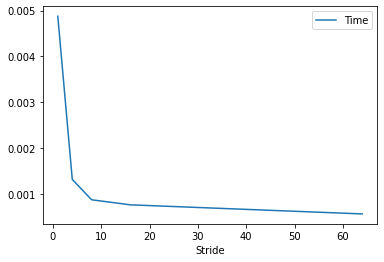

In [38]:
plt.close('all')
q = 'Device == "cuda" and Input_Feature == 2048 and Output_Feature == 2048 and Length == 2048 and Kernel == 1'
df_ = df.query(q)
display(df_)
df_.plot(x='Stride',y='Time')
path = dir_ / 'Stride.png'
plt.savefig(path)

## 回帰層

In [45]:
dir_ = root / 'LSTM'
dir_.mkdir(parents=True, exist_ok=True)
csv_path = dir_ / 'result.csv'

In [46]:
hidden_features = [16, 64, 256, 1024]
num_layers = [2, 4]
bidirectional = [True, False]

looper = product(batches, features, lengths, hidden_features, num_layers, bidirectional, devices)

column = ['Batch', 'Input_Feature', 'Length', 'Hidden_Feature', 'Layer', 'Bidirectional', 'Device', 'Time', 'Mult-Adds', 'Params']

In [47]:
if csv_path.exists():
  df = pd.read_csv(csv_path)
else:
  data = []
  looper = tqdm(list(looper), leave=True)

  for B, Fin, L, Fhid, Layer, Bi, D in looper:
    looper.set_description(f'Fin: {Fin}, L: {L}, Fhid: {Fhid}, Layer: {Layer}, Bi: {Bi}')
    x = torch.rand(B, L, Fin, device=D)
    layer = nn.LSTM(Fin, Fhid, Layer, bidirectional=Bi, batch_first=True, device=D)
    stats = summary(layer, input_data=x, verbose=0, device=D)
    with torch.no_grad():
      _ = layer(x)

    t = 0
    for _ in range(n_iter):
      torch.cuda.synchronize()
      start = time()

      with torch.no_grad():
        _ = layer(x)

      torch.cuda.synchronize()
      elapsed = time() - start
      t += elapsed

    avg = t / n_iter
    mads = stats.total_mult_adds
    params = stats.total_params
    col = [B, Fin, L, Fhid, Layer, Bi, D, avg, mads, params]
    data.append(col)


  df = pd.DataFrame(data, columns=column)
  df.to_csv(csv_path)

  0%|          | 0/400 [00:00<?, ?it/s]

,Batch,Input_Feature,Length,Hidden_Feature,Layer,Bidirectional,Device,Time,Mult-Adds,Params
334,1,2048,16,1024,4,True,cuda,0.010967,1611661312,100728832
350,1,2048,64,1024,4,True,cuda,0.039516,6446645248,100728832
366,1,2048,256,1024,4,True,cuda,0.153016,25786580992,100728832
382,1,2048,1024,1024,4,True,cuda,0.596987,103146323968,100728832
398,1,2048,2048,1024,4,True,cuda,1.185756,206292647936,100728832


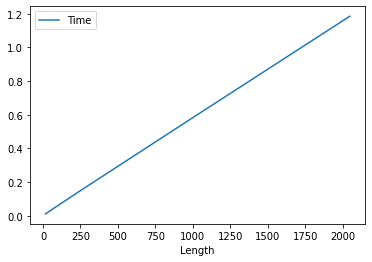

In [48]:
plt.close('all')
q = 'Device == "cuda" and Input_Feature == 2048 and Hidden_Feature == 1024 and Layer == 4 and Bidirectional == True'
df_ = df.query(q)
display(df_)
df_.plot(x='Length',y='Time')
path = dir_ / 'Length.png'
plt.savefig(path)

,Batch,Input_Feature,Length,Hidden_Feature,Layer,Bidirectional,Device,Time,Mult-Adds,Params
78,1,16,2048,1024,4,True,cuda,1.172286,172201345024,84082688
158,1,64,2048,1024,4,True,cuda,1.174514,173006651392,84475904
238,1,256,2048,1024,4,True,cuda,1.174928,176227876864,86048768
318,1,1024,2048,1024,4,True,cuda,1.179051,189112778752,92340224
398,1,2048,2048,1024,4,True,cuda,1.185756,206292647936,100728832


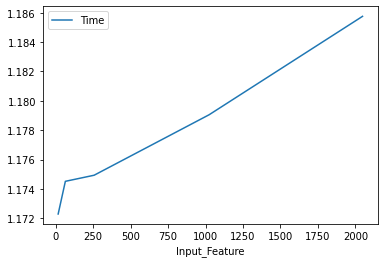

In [49]:
plt.close('all')
q = 'Device == "cuda" and Length == 2048 and Hidden_Feature == 1024 and Layer == 4 and Bidirectional == True'
df_ = df.query(q)
display(df_)
df_.plot(x='Input_Feature',y='Time')
path = dir_ / 'Input_Feature.png'
plt.savefig(path)

,Batch,Input_Feature,Length,Hidden_Feature,Layer,Bidirectional,Device,Time,Mult-Adds,Params
386,1,2048,2048,16,4,True,cuda,0.012140,580911104,283648
390,1,2048,2048,64,4,True,cuda,0.012687,2826960896,1380352
394,1,2048,2048,256,4,True,cuda,0.120724,19360907264,9453568
398,1,2048,2048,1024,4,True,cuda,1.185756,206292647936,100728832


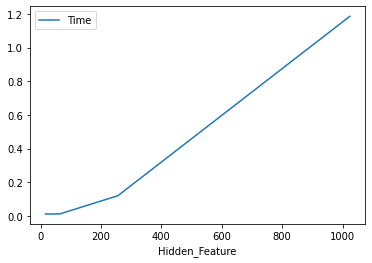

In [50]:
plt.close('all')
q = 'Device == "cuda" and Length == 2048 and Input_Feature == 2048 and Layer == 4 and Bidirectional == True'
df_ = df.query(q)
display(df_)
df_.plot(x='Hidden_Feature',y='Time')
path = dir_ / 'Hidden_Feature.png'
plt.savefig(path)

,Batch,Input_Feature,Length,Hidden_Feature,Layer,Bidirectional,Device,Time,Mult-Adds,Params
396,1,2048,2048,1024,2,True,cuda,0.593152,103146323968,50364416
398,1,2048,2048,1024,4,True,cuda,1.185756,206292647936,100728832


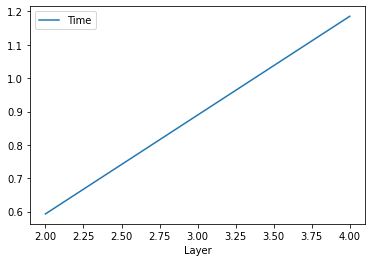

In [51]:
plt.close('all')
q = 'Device == "cuda" and Length == 2048 and Input_Feature == 2048 and Hidden_Feature == 1024 and Bidirectional == True'
df_ = df.query(q)
display(df_)
df_.plot(x='Layer',y='Time')
path = dir_ / 'Layer.png'
plt.savefig(path)

,Batch,Input_Feature,Length,Hidden_Feature,Layer,Bidirectional,Device,Time,Mult-Adds,Params
398,1,2048,2048,1024,4,True,cuda,1.185756,206292647936,100728832
399,1,2048,2048,1024,4,False,cuda,0.578386,77376520192,37781504


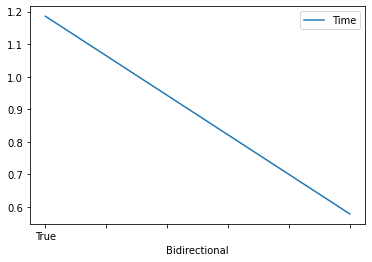

In [52]:
plt.close('all')
q = 'Device == "cuda" and Length == 2048 and Input_Feature == 2048 and Hidden_Feature == 1024 and Layer == 4'
df_ = df.query(q)
display(df_)
df_.plot(x='Bidirectional',y='Time')
path = dir_ / 'Bidirectional.png'
plt.savefig(path)

## 複数ヘッド注意

In [39]:
dir_ = root / 'MHA'
dir_.mkdir(parents=True, exist_ok=True)
csv_path = dir_ / 'result.csv'

In [40]:
num_heads = [1, 2, 4, 8, 16]

looper = product(batches, features, lengths, num_heads, devices)

column = ['Batch', 'Input_Feature', 'Length', 'Head', 'Device', 'Time', 'Mult-Adds', 'Params']

In [41]:
if csv_path.exists():
  df = pd.read_csv(csv_path)
else:
  data = []
  looper = tqdm(list(looper), leave=True)

  for B, Fin, L, H, D in looper:
    x = torch.rand(B, L, Fin, device=D)
    layer = nn.MultiheadAttention(Fin, H, batch_first=True, device=D)
    stats = summary(layer, input_data=[x, x, x], verbose=0, device=D)
    with torch.no_grad():
      _ = layer(x, x, x)

    t = 0
    for _ in range(n_iter):
      torch.cuda.synchronize()
      start = time()

      with torch.no_grad():
        _ = layer(x, x, x)

      torch.cuda.synchronize()
      elapsed = time() - start
      t += elapsed

    avg = t / n_iter
    mads = stats.total_mult_adds
    params = stats.total_params
    col = [B, Fin, L, H, D, avg, mads, params]
    data.append(col)


  df = pd.DataFrame(data, columns=column)
  df.to_csv(csv_path)

  0%|          | 0/125 [00:00<?, ?it/s]

,Batch,Input_Feature,Length,Head,Device,Time,Mult-Adds,Params
104,1,2048,16,16,cuda,0.000613,0,16785408
109,1,2048,64,16,cuda,0.000902,0,16785408
114,1,2048,256,16,cuda,0.003081,0,16785408
119,1,2048,1024,16,cuda,0.014587,0,16785408
124,1,2048,2048,16,cuda,0.033291,0,16785408


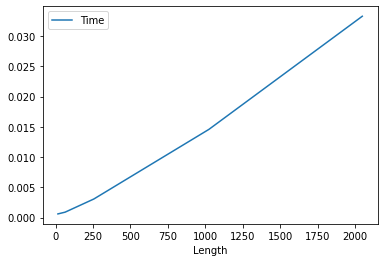

In [42]:
plt.close('all')
q = 'Device == "cuda" and Input_Feature == 2048 and Head == 16'
df_ = df.query(q)
display(df_)
df_.plot(x='Length',y='Time')
path = dir_ / 'Length.png'
plt.savefig(path)

,Batch,Input_Feature,Length,Head,Device,Time,Mult-Adds,Params
24,1,16,2048,16,cuda,0.008286,0,1088
49,1,64,2048,16,cuda,0.008846,0,16640
74,1,256,2048,16,cuda,0.007849,0,263168
99,1,1024,2048,16,cuda,0.014909,0,4198400
124,1,2048,2048,16,cuda,0.033291,0,16785408


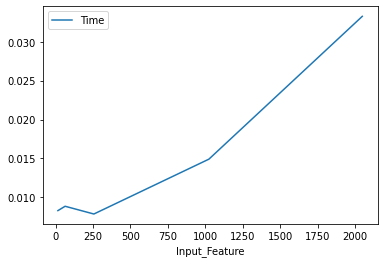

In [43]:
plt.close('all')
q = 'Device == "cuda" and Length == 2048 and Head == 16'
df_ = df.query(q)
display(df_)
df_.plot(x='Input_Feature',y='Time')
path = dir_ / 'Input_Feature.png'
plt.savefig(path)

,Batch,Input_Feature,Length,Head,Device,Time,Mult-Adds,Params
120,1,2048,2048,1,cuda,0.029174,0,16785408
121,1,2048,2048,2,cuda,0.029793,0,16785408
122,1,2048,2048,4,cuda,0.030180,0,16785408
123,1,2048,2048,8,cuda,0.031228,0,16785408
124,1,2048,2048,16,cuda,0.033291,0,16785408


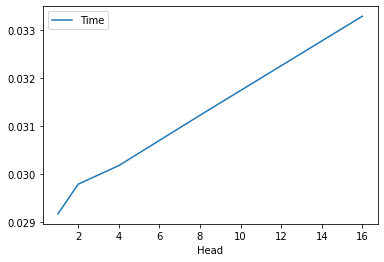

In [44]:
plt.close('all')
q = 'Device == "cuda" and Length == 2048 and Input_Feature == 2048'
df_ = df.query(q)
display(df_)
df_.plot(x='Head',y='Time')
path = dir_ / 'Head.png'
plt.savefig(path)